In [47]:
import matplotlib.pyplot as plt
import numpy as np
import cmath
from scipy.integrate import simpson
from trinity_plotting import set_plot_style

set_plot_style(style="light")

<Figure size 960x720 with 0 Axes>

In [ ]:
# MY EQUATION

# --- constants ---
alpha = 1/137.035999084
v = 246.0
mW, mH, GammaH = 80.379, 125.25, 4.07e-3
mtop = 172.5
Nc_top, Q_top = 3, 2/3

# Unit conversions
HC2_GEV2_TO_M2 = 3.89379e-32   # 1 GeV^-2 = 3.89379e-32 m^2  (fixed)
GEV2_TO_FB     = 3.89379e11    # 1 GeV^-2 = 3.89379e11 fb

# ---------- Loop functions (H -> γγ) ----------

def f_scalar(tau):
    """
    f(τ) loop function
    Works for scalar or numpy array τ (real or complex)
    """
    tau_arr = np.asarray(tau, dtype=complex)
    out = np.zeros_like(tau_arr, dtype=complex)

    # τ ≥ 1  → real arcsin branch
    mask_real = tau_arr.real >= 1.0
    if np.any(mask_real):
        out[mask_real] = np.arcsin(1.0 / np.sqrt(tau_arr[mask_real]))**2

    # τ < 1  → complex log branch
    mask_cmplx = ~mask_real
    if np.any(mask_cmplx):
        root = np.sqrt(1.0 - tau_arr[mask_cmplx])
        out[mask_cmplx] = -0.25 * (np.log((1 + root) / (1 - root)) - 1j*np.pi)**2

    if np.ndim(tau) == 0:
        return out.item()
    return out


def A1_over2(tau):  # spin-1/2
    tau_arr = np.asarray(tau, dtype=complex)
    return -2.0 * (1.0 + (1.0 - tau_arr) * f_scalar(tau_arr))


def A1(tau):        # spin-1
    tau_arr = np.asarray(tau, dtype=complex)
    return 2.0 + 3.0 * tau_arr + 3.0 * (2.0 * tau_arr - tau_arr**2) * f_scalar(tau_arr)

def IW_IF_from_t(t, mW_, mferm_, eps=1e-18):
    t = np.asarray(t, dtype=float)
    IW = np.zeros_like(t, dtype=complex)
    IF = np.zeros_like(t, dtype=complex)
    safe = ~np.isclose(t, 0.0, atol=eps, rtol=0.0)
    if np.any(safe):
        betaW = -4.0*(mW_**2)/t[safe]
        betaf = -4.0*(mferm_**2)/t[safe]
        IW[safe] = A1(betaW)
        IF[safe] = A1_over2(betaf)
    return (IW.item(), IF.item()) if IW.ndim == 0 else (IW, IF)


# ---------- Kinematics ----------
def get_s_cm(mchi, k):
    """CoM frame: s = (sqrt(mchi^2 + k^2) + k)^2, with k = E_gamma."""
    return (np.sqrt(mchi**2 + k**2) + k)**2

def get_s_lab_DMrest(mchi, omega):
    """Lab frame (DM at rest): s = mchi^2 + 2 mchi * omega."""
    return mchi**2 + 2*mchi*omega

def get_t_cm(Eg, theta):
    """CoM frame: t = -2 Eg^2 (1 - cos(theta))."""
    return -2.0 * Eg**2 * (1.0 - np.cos(theta))

def get_t_lab_DMrest(mchi, omega, theta):
    """
    Lab frame (DM at rest): Compton-like kinematics with m_e -> mchi.
    omega' = omega / (1 + (omega/mchi)*(1-cosθ))
    t = -2 * omega * omega' * (1 - cosθ)
    """
    denom = 1.0 + (omega/mchi)*(1.0 - np.cos(theta))
    omega_out = omega / denom
    return -2.0 * omega * omega_out * (1.0 - np.cos(theta))

# ---------- dσ/dΩ ----------
def get_dsigma_dOmega(mchi, theta, E_gamma, *,
                      frame="cm",      # "cm" or "lab"
                      in_SI=False,
                      mW_=mW, mH_=mH, GammaH_=GammaH,
                      mferm_=mtop, Nc_=Nc_top, Qf_=Q_top, which="full"):
    """
    mchi    : GeV
    theta   : radians
    E_gamma : photon energy (GeV). Interpreted as:
              - CM photon energy if frame="cm"
              - Lab incoming photon energy (DM at rest) if frame="lab"
    returns : fb/sr (default) or m^2/sr if in_SI=True
    """
    if frame == "lab":
        s = get_s_lab_DMrest(mchi, E_gamma)
        t = get_t_lab_DMrest(mchi, E_gamma, theta)
    else:
        s = get_s_cm(mchi, E_gamma)
        t = get_t_cm(E_gamma, theta)
    # couplings & loops
    gW = 2.0 * mW_ / v
    IW, IF = IW_IF_from_t(t, mW_, mferm_)

    if which == "F": # fermion - computes for only top quark as dominant
        amp = Nc_ * (Qf_**2) * IF
        amp2 = (amp * np.conjugate(amp)).real
    elif which == "W": # W boson
        amp = IW
        amp2 = (amp * np.conjugate(amp)).real
    else: # both
        amp = IW + Nc_ * (Qf_**2) * IF
        amp2 = (amp * np.conjugate(amp)).real

    pref  = (alpha**2) * (gW**4) * (mchi**2) / ((16.0*np.pi)**2 * (mW_**4))

    tpart = 3.0*(t**2)/8.0  

    prop  =  (2.0*mchi**2 - 0.5*t) / (((t - mH_**2)**2) + (mH_**2)*(GammaH_**2))

    phase = amp2 / (64.0 * (np.pi**2) * s)


    val = pref * tpart * prop * phase  # GeV^-2 / sr
    return val * (HC2_GEV2_TO_M2 if in_SI else GEV2_TO_FB)


In [49]:
mchi = 1000.0  #1 TeV as in paper

angles = np.linspace(0, 180, 100)
angles_rad = np.deg2rad(angles)

Eg_1GeV = np.ones(len(angles_rad)) * 1 #GeV
Eg_50GeV = np.ones(len(angles_rad)) * 50 #GeV
Eg_500GeV = np.ones(len(angles_rad)) * 500 #GeV
Eg_800GeV = np.ones(len(angles_rad)) * 800 #GeV

dsig_domega_Eg_1GeV = get_dsigma_dOmega(mchi, angles_rad, Eg_1GeV)
dsig_domega_Eg_50GeV = get_dsigma_dOmega(mchi, angles_rad, Eg_50GeV)
dsig_domega_Eg_500GeV = get_dsigma_dOmega(mchi, angles_rad, Eg_500GeV)
dsig_domega_Eg_800GeV = get_dsigma_dOmega(mchi, angles_rad, Eg_800GeV)


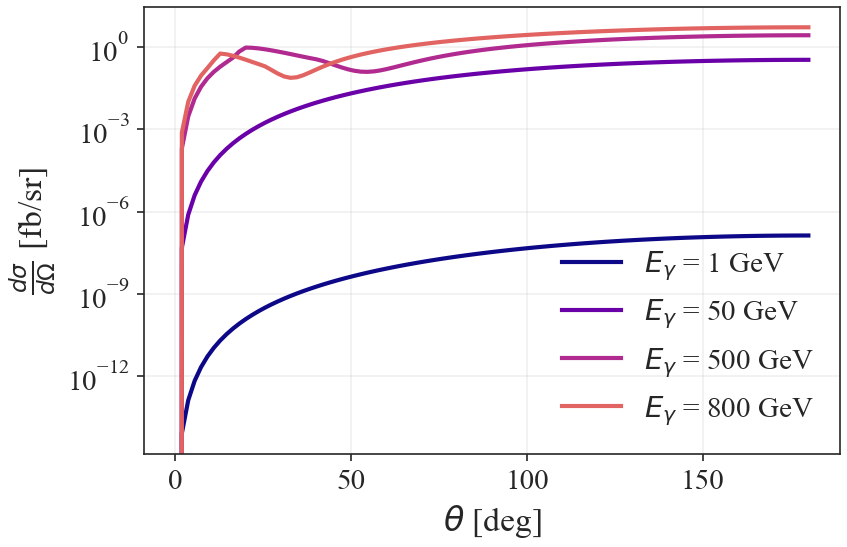

In [50]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(angles, dsig_domega_Eg_1GeV, label=r"$E_{\gamma}$ = 1 GeV")
ax.plot(angles, dsig_domega_Eg_50GeV, label=r"$E_{\gamma}$ = 50 GeV")
ax.plot(angles, dsig_domega_Eg_500GeV, label=r"$E_{\gamma}$ = 500 GeV")
ax.plot(angles, dsig_domega_Eg_800GeV, label=r"$E_{\gamma}$ = 800 GeV")
ax.set_xlabel(r"$\theta$ [deg]")
ax.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ [fb/sr]")
plt.legend()
#plt.title("Dependence of Differential Cross Section on Angle")
plt.yscale("log")

plt.savefig("plots/Weakly_dep_on_angle.png")
plt.show()

In [51]:
mchi = 1000.0  #1 TeV as in paper

energies = np.linspace(0, 1000, 200)

angle10 = np.ones(len(energies)) * np.deg2rad(10) #rad
angle60 = np.ones(len(energies)) * np.deg2rad(60) #rad
angle90 = np.ones(len(energies)) * np.deg2rad(90) #rad
angle180 = np.ones(len(energies)) * np.deg2rad(180) #rad

dsig_domega_10deg = get_dsigma_dOmega(mchi, angle10, energies)
dsig_domega_60deg = get_dsigma_dOmega(mchi, angle60, energies)
dsig_domega_90deg = get_dsigma_dOmega(mchi, angle90, energies)
dsig_domega_180deg = get_dsigma_dOmega(mchi, angle180, energies)


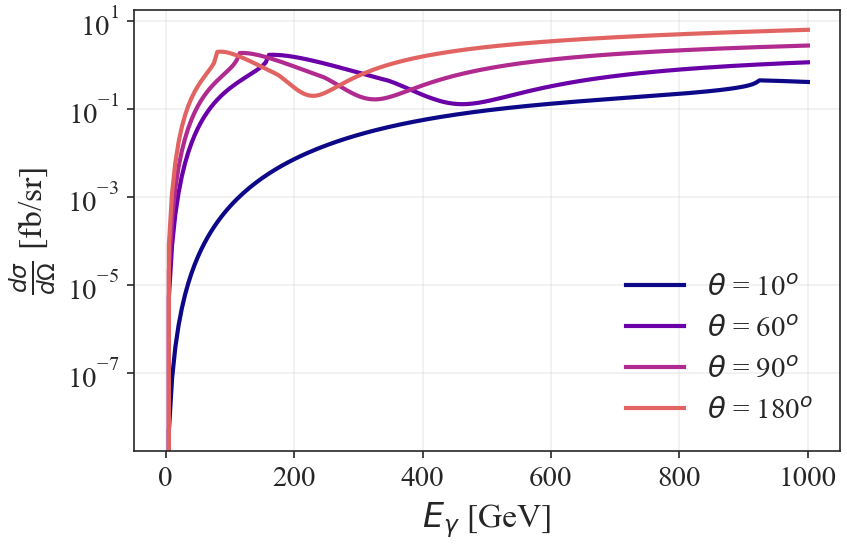

In [52]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(energies, dsig_domega_10deg, label=r"$\theta$ = 10$^o$")
ax.plot(energies, dsig_domega_60deg, label=r"$\theta$ = 60$^o$")
ax.plot(energies, dsig_domega_90deg, label=r"$\theta$ = 90$^o$")
ax.plot(energies, dsig_domega_180deg, label=r"$\theta$ = 180$^o$")
ax.set_xlabel(r"$E_{\gamma}$ [GeV]")
ax.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ [fb/sr]")
plt.legend()
#plt.title("Dependence of Differential Cross Section on Photon Energy")
plt.yscale("log")

plt.savefig("plots/Weakly_dep_on_egamma.png")
plt.show()

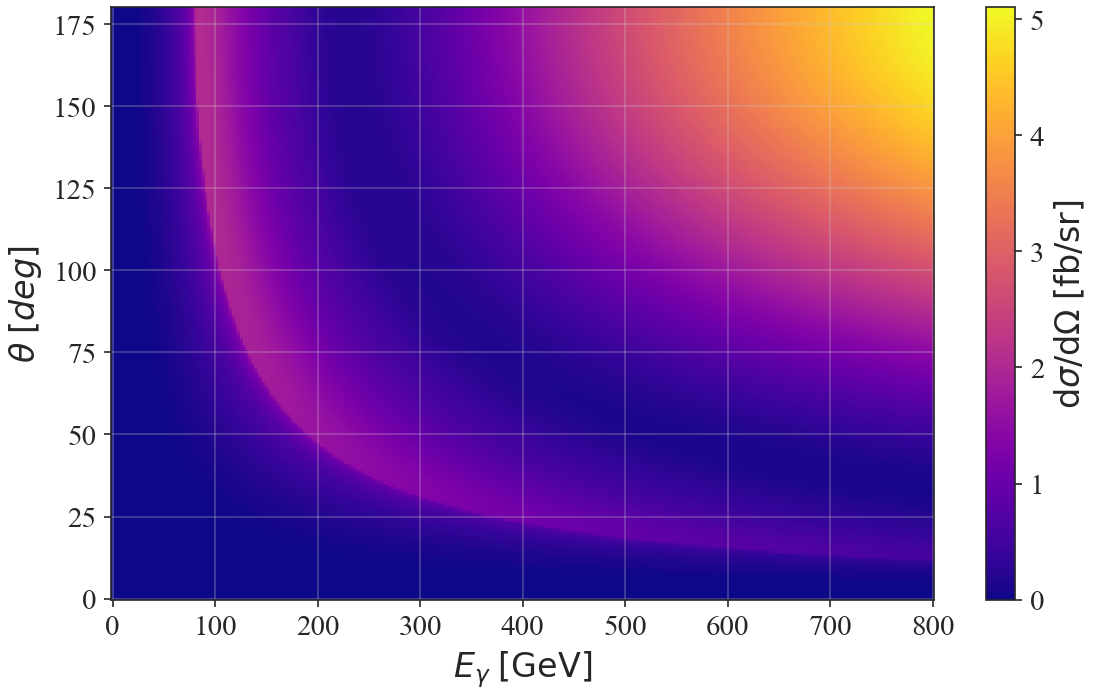

In [ ]:
mchi  = 1e3       # GeV

energies   = np.linspace(1e-3, 800, 300)               # GeV
angles_deg = np.linspace(1e-3, 179.9, 240)              # deg
angles_rad = np.deg2rad(angles_deg)                    # rad

theta_grid = angles_rad[:, None]    
Eg_grid    = energies[None, :]         
dsig = get_dsigma_dOmega(mchi, theta_grid, Eg_grid)  # fb/sr

# Plot
fig, ax = plt.subplots(figsize=(8,5))
im = ax.pcolormesh(
    energies, angles_deg, dsig,
    shading="auto",
)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label(r'$\mathrm{d}\sigma/\mathrm{d}\Omega\;[\mathrm{fb/sr}]$')

ax.set_xlabel(r'$E_\gamma\;[\mathrm{GeV}]$')
ax.set_ylabel(r'$\theta\;[deg]$')
#ax.set_title(fr'$\chi\gamma \to \chi\gamma$') #cm frame

plt.tight_layout()
plt.savefig("plots/Weakly_egamma_vs_angle.png")
plt.show()


In [54]:
def sigma_total(mchi, Eg, *, which="full"):
    theta = np.linspace(1e-6, np.pi, 100)  # radians, avoid 0
    ftheta = np.sin(theta)*get_dsigma_dOmega(mchi, theta, Eg, frame="cm", which=which)
    return 2.0*np.pi*simpson(ftheta, theta)  # fb

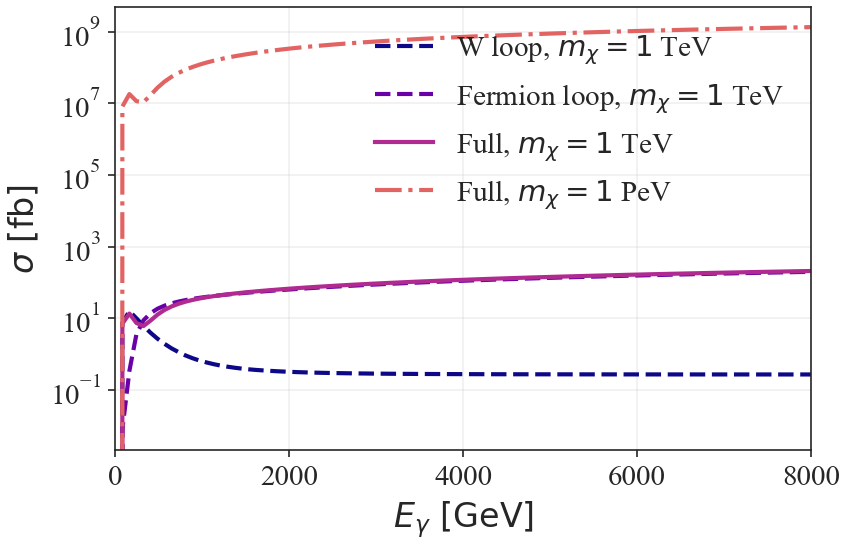

In [61]:

Egrid = np.linspace(0, 8000, 100)   # GeV (avoid Eg=0)
mchi_1TeV = 1.0e3
mchi_1PeV = 1.0e6

sigma_W_1TeV     = np.array([sigma_total(mchi_1TeV, Eg, which="W") for Eg in Egrid])
sigma_F_1TeV     = np.array([sigma_total(mchi_1TeV, Eg, which="F")    for Eg in Egrid])
sigma_full_1TeV  = np.array([sigma_total(mchi_1TeV, Eg, which="full") for Eg in Egrid])
sigma_full_1PeV  = np.array([sigma_total(mchi_1PeV, Eg, which="full") for Eg in Egrid])

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(Egrid, sigma_W_1TeV,     '--',  label=r'W loop, $m_\chi=1$ TeV')
ax.plot(Egrid, sigma_F_1TeV,     '--',  label=r'Fermion loop, $m_\chi=1$ TeV')
ax.plot(Egrid, sigma_full_1TeV,  '-',   label=r'Full, $m_\chi=1$ TeV')
ax.plot(Egrid, sigma_full_1PeV,  '-.',  label=r'Full, $m_\chi=1$ PeV')
ax.set_xlim(0, 8000)
ax.set_xlabel(r'$E_\gamma\ \mathrm{[GeV]}$')
ax.set_ylabel(r'$\sigma\ \mathrm{[fb]}$')
#ax.set_title(r'$\chi\gamma \to \chi\gamma$ total cross section (Centre of Mass frame)')
ax.legend(frameon=False, loc='upper right')
ax.set_yscale('log')
plt.tight_layout()
plt.savefig("plots/Weakly_full_log.png")
plt.show()


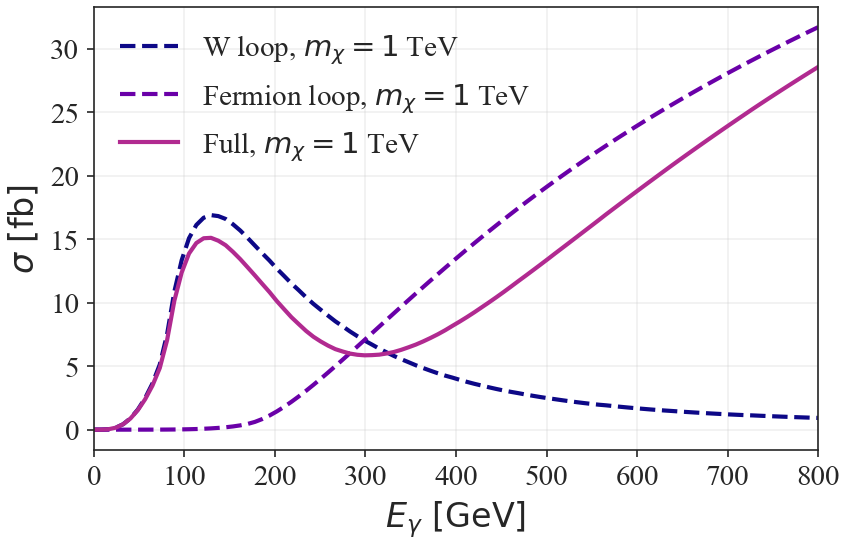

In [62]:
Egrid = np.linspace(0.1, 800, 100)   # GeV (avoid Eg=0)
mchi_1TeV = 1.0e3
mchi_1PeV = 1.0e6

sigma_W_1TeV     = np.array([sigma_total(mchi_1TeV, Eg, which="W") for Eg in Egrid])
sigma_F_1TeV     = np.array([sigma_total(mchi_1TeV, Eg, which="F")    for Eg in Egrid])
sigma_full_1TeV  = np.array([sigma_total(mchi_1TeV, Eg, which="full") for Eg in Egrid])
#sigma_full_1PeV  = np.array([sigma_total(mchi_1PeV, Eg, which="full") for Eg in Egrid])

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(Egrid, sigma_W_1TeV,     '--',  label=r'W loop, $m_\chi=1$ TeV')
ax.plot(Egrid, sigma_F_1TeV,     '--',  label=r'Fermion loop, $m_\chi=1$ TeV')
ax.plot(Egrid, sigma_full_1TeV,  '-',   label=r'Full, $m_\chi=1$ TeV')
#ax.plot(Egrid, sigma_full_1PeV,  '-.',  label=r'Full $\times 10^6,\ m_\chi=1$ PeV')
ax.set_xlim(0, 800)
ax.set_xlabel(r'$E_\gamma\ \mathrm{[GeV]}$')
ax.set_ylabel(r'$\sigma\ \mathrm{[fb]}$')
#ax.set_title(r'$\chi\gamma \to \chi\gamma$ total cross section (Centre of Mass frame)')
ax.legend(frameon=False, loc='upper left')
#ax.set_yscale('log')
plt.savefig("plots/Weakly_full_no_log.png")
plt.tight_layout()
plt.show()


In [63]:
# PAPER EQUATION

# ---------- dσ/dΩ ----------
def get_paper_dsigma_dOmega(mchi, theta, E_gamma, *,
                      frame="cm",      # "cm" or "lab"
                      in_SI=False,
                      mW_=mW, mH_=mH, GammaH_=GammaH,
                      mferm_=mtop, Nc_=Nc_top, Qf_=Q_top, which="full"):
    """
    mchi    : GeV
    theta   : radians
    E_gamma : photon energy (GeV). Interpreted as:
              - CM photon energy if frame="cm"
              - Lab incoming photon energy (DM at rest) if frame="lab"
    returns : fb/sr (default) or m^2/sr if in_SI=True
    """
    if frame == "lab":
        s = get_s_lab_DMrest(mchi, E_gamma)
        t = get_t_lab_DMrest(mchi, E_gamma, theta)
    else:
        s = get_s_cm(mchi, E_gamma)
        t = get_t_cm(E_gamma, theta)
    # couplings & loops
    gW = 2.0 * mW_ / v
    IW, IF = IW_IF_from_t(t, mW_, mferm_)

    if which == "F": # fermion - computes for only top quark as dominant
        amp = Nc_ * (Qf_**2) * (IF**2)
        amp2 = (amp * np.conjugate(amp)).real
    elif which == "W": # W boson
        amp = IW
        amp2 = (amp * np.conjugate(amp)).real
    else: # both
        amp = IW + Nc_ * (Qf_**2) * (IF**2)
        amp2 = (amp * np.conjugate(amp)).real

    pref  = (alpha*42) * (gW**4) * (mchi**2) / ((4.0*np.pi)**2 * (mW_**4))

    tpart = 3.0*(t**2)/4.0  

    prop  =  (2.0*mchi**2 - 0.5*t) / (((t - mH_**2)**2) + (mH_**2)*(GammaH_**2))

    phase = amp2 / (64.0 * (np.pi**2) * s)


    val = pref * tpart * prop * phase  # GeV^-2 / sr
    return val * (HC2_GEV2_TO_M2 if in_SI else GEV2_TO_FB)


In [64]:
mchi = 1000.0  #1 TeV as in paper

angles = np.linspace(0, 180, 100)
angles_rad = np.deg2rad(angles)

Eg_1GeV = np.ones(len(angles_rad)) * 1 #GeV
Eg_50GeV = np.ones(len(angles_rad)) * 50 #GeV
Eg_500GeV = np.ones(len(angles_rad)) * 500 #GeV
Eg_800GeV = np.ones(len(angles_rad)) * 800 #GeV

dsig_domega_Eg_1GeV = get_paper_dsigma_dOmega(mchi, angles_rad, Eg_1GeV)
dsig_domega_Eg_50GeV = get_paper_dsigma_dOmega(mchi, angles_rad, Eg_50GeV)
dsig_domega_Eg_500GeV = get_paper_dsigma_dOmega(mchi, angles_rad, Eg_500GeV)
dsig_domega_Eg_800GeV = get_paper_dsigma_dOmega(mchi, angles_rad, Eg_800GeV)


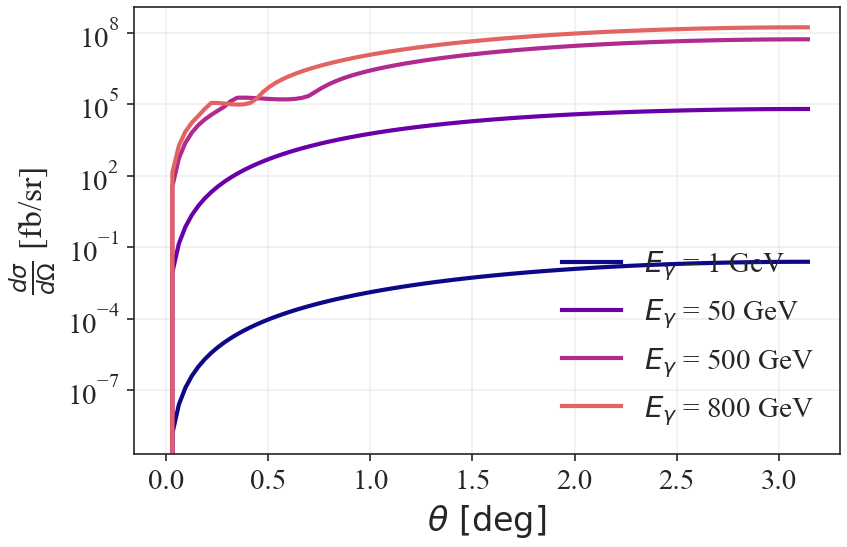

In [65]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(angles_rad, dsig_domega_Eg_1GeV, label=r"$E_{\gamma}$ = 1 GeV")
ax.plot(angles_rad, dsig_domega_Eg_50GeV, label=r"$E_{\gamma}$ = 50 GeV")
ax.plot(angles_rad, dsig_domega_Eg_500GeV, label=r"$E_{\gamma}$ = 500 GeV")
ax.plot(angles_rad, dsig_domega_Eg_800GeV, label=r"$E_{\gamma}$ = 800 GeV")
#plt.title("Dependence of Differential Cross Section on Angle (Paper Version)")
plt.legend()
plt.ylabel(r"$\frac{d\sigma}{d\Omega}$ [fb/sr]")
plt.xlabel(r'$\theta\ \mathrm{[deg]}$')
plt.yscale("log")
plt.savefig("plots/Weakly_dep_on_angle_theirs.png")
plt.show()

In [66]:
mchi = 1000.0  #1 TeV as in paper

energies = np.linspace(0, 800, 100)

angle10 = np.ones(len(energies)) * np.deg2rad(10) #rad
angle60 = np.ones(len(energies)) * np.deg2rad(60) #rad
angle90 = np.ones(len(energies)) * np.deg2rad(90) #rad
angle180 = np.ones(len(energies)) * np.deg2rad(180) #rad

dsig_domega_10deg = get_paper_dsigma_dOmega(mchi, angle10, energies)
dsig_domega_60deg = get_paper_dsigma_dOmega(mchi, angle60, energies)
dsig_domega_90deg = get_paper_dsigma_dOmega(mchi, angle90, energies)
dsig_domega_180deg = get_paper_dsigma_dOmega(mchi, angle180, energies)


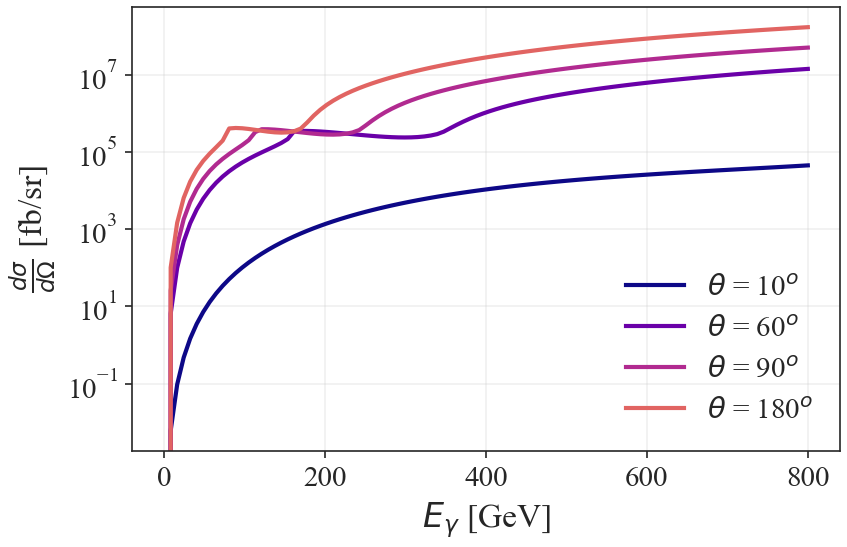

In [67]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(energies, dsig_domega_10deg, label=r"$\theta$ = 10$^o$")
ax.plot(energies, dsig_domega_60deg, label=r"$\theta$ = 60$^o$")
ax.plot(energies, dsig_domega_90deg, label=r"$\theta$ = 90$^o$")
ax.plot(energies, dsig_domega_180deg, label=r"$\theta$ = 180$^o$")
plt.xlabel(r"$E_{\gamma}$ [GeV]")
#plt.title("Dependence of Differential Cross Section on Egamma (Paper Version)")
plt.ylabel(r"$\frac{d\sigma}{d\Omega}$ [fb/sr]")
plt.legend(loc="lower right")
plt.yscale("log")
plt.savefig("plots/Weakly_dep_on_egamma_theirs.png")
plt.show()

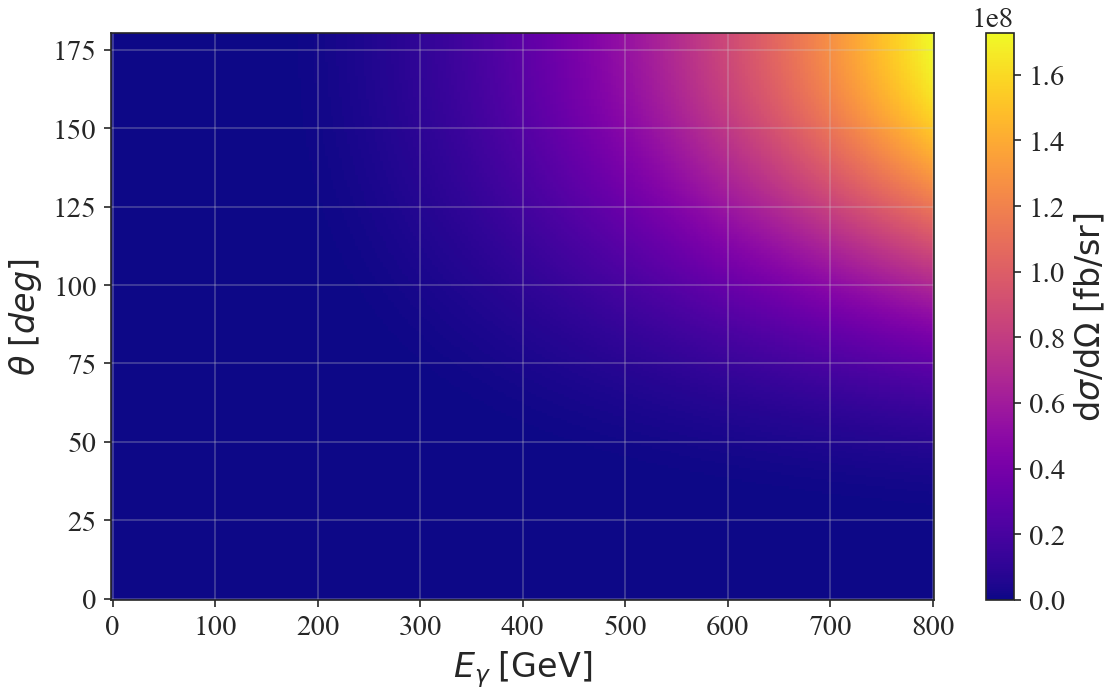

In [68]:
mchi  = 1e3       # GeV

energies   = np.linspace(1e-3, 800, 300)               # GeV
angles_deg = np.linspace(1e-3, 179.9, 240)              # deg
angles_rad = np.deg2rad(angles_deg)                    # rad

theta_grid = angles_rad[:, None]      
Eg_grid    = energies[None, :]        
dsig = get_paper_dsigma_dOmega(mchi, theta_grid, Eg_grid)  # fb/sr

# Plot
fig, ax = plt.subplots(figsize=(8,5))
im = ax.pcolormesh(
    energies, angles_deg, dsig,
    shading="auto",
)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label(r'$\mathrm{d}\sigma/\mathrm{d}\Omega\;[\mathrm{fb/sr}]$')

ax.set_xlabel(r'$E_\gamma\;[\mathrm{GeV}]$')
ax.set_ylabel(r'$\theta\;[deg]$')
#ax.set_title(fr'$\chi\gamma \to \chi\gamma$') #cm frame

plt.tight_layout()
plt.savefig("plots/Weakly_egamma_vs_angle_theirs.png")
plt.show()


In [69]:
def sigma_total_paper(mchi, Eg, *, which="full"):
    theta = np.linspace(1e-6, np.pi, 100)  # radians, avoid 0
    ftheta = np.sin(theta)*get_paper_dsigma_dOmega(mchi, theta, Eg, frame="cm", which=which)
    return 2.0*np.pi*simpson(ftheta, theta)  # fb

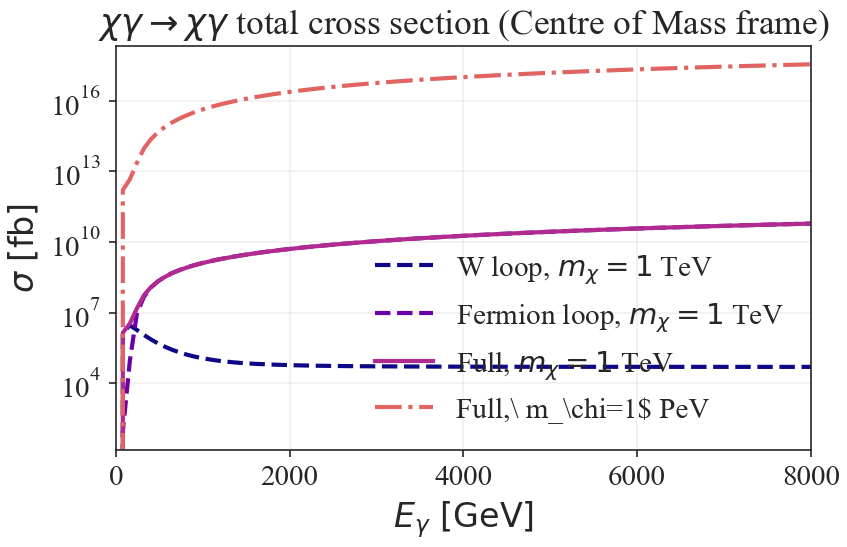

In [70]:
Egrid = np.linspace(0, 8000, 100)   # GeV (avoid Eg=0)
mchi_1TeV = 1.0e3
mchi_1PeV = 1.0e6

sigma_W_1TeV     = np.array([sigma_total_paper(mchi_1TeV, Eg, which="W") for Eg in Egrid])
sigma_F_1TeV     = np.array([sigma_total_paper(mchi_1TeV, Eg, which="F")    for Eg in Egrid])
sigma_full_1TeV  = np.array([sigma_total_paper(mchi_1TeV, Eg, which="full") for Eg in Egrid])
sigma_full_1PeV  = np.array([sigma_total_paper(mchi_1PeV, Eg, which="full") for Eg in Egrid])

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(Egrid, sigma_W_1TeV,     '--',  label=r'W loop, $m_\chi=1$ TeV')
ax.plot(Egrid, sigma_F_1TeV,     '--',  label=r'Fermion loop, $m_\chi=1$ TeV')
ax.plot(Egrid, sigma_full_1TeV,  '-',   label=r'Full, $m_\chi=1$ TeV')
ax.plot(Egrid, sigma_full_1PeV,  '-.',  label=r'Full,\ m_\chi=1$ PeV')
ax.set_xlim(0, 8000)
ax.set_xlabel(r'$E_\gamma\ \mathrm{[GeV]}$')
ax.set_ylabel(r'$\sigma\ \mathrm{[fb]}$')
ax.set_title(r'$\chi\gamma \to \chi\gamma$ total cross section (Centre of Mass frame)')
ax.legend(frameon=False, loc='lower right')
ax.set_yscale('log')
plt.tight_layout()
plt.show()


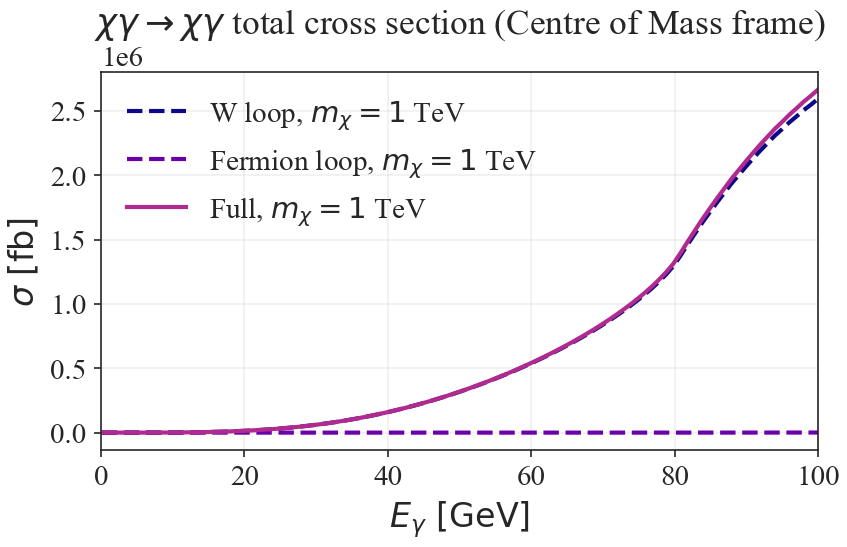

In [71]:
Egrid = np.linspace(0.1, 100, 100)   # GeV (avoid Eg=0)
mchi_1TeV = 1.0e3
mchi_1PeV = 1.0e6

sigma_W_1TeV     = np.array([sigma_total_paper(mchi_1TeV, Eg, which="W") for Eg in Egrid])
sigma_F_1TeV     = np.array([sigma_total_paper(mchi_1TeV, Eg, which="F")    for Eg in Egrid])
sigma_full_1TeV  = np.array([sigma_total_paper(mchi_1TeV, Eg, which="full") for Eg in Egrid])
#sigma_full_1PeV  = np.array([sigma_total_paper(mchi_1PeV, Eg, which="full") for Eg in Egrid])

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(Egrid, sigma_W_1TeV,     '--',  label=r'W loop, $m_\chi=1$ TeV')
ax.plot(Egrid, sigma_F_1TeV,     '--',  label=r'Fermion loop, $m_\chi=1$ TeV')
ax.plot(Egrid, sigma_full_1TeV,  '-',   label=r'Full, $m_\chi=1$ TeV')
#ax.plot(Egrid, sigma_full_1PeV,  '-.',  label=r'Full $\times 10^6,\ m_\chi=1$ PeV')
ax.set_xlim(0, 100)
ax.set_xlabel(r'$E_\gamma\ \mathrm{[GeV]}$')
ax.set_ylabel(r'$\sigma\ \mathrm{[fb]}$')
ax.set_title(r'$\chi\gamma \to \chi\gamma$ total cross section (Centre of Mass frame)')
ax.legend(frameon=False, loc='upper left')
#ax.set_yscale('log')
plt.tight_layout()
plt.show()
